In [61]:
from torchinfo import summary
from fvcore.nn import FlopCountAnalysis
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from lightning.pytorch import seed_everything
import lightning as L
import torch
import seaborn as sns
import numpy as np
import json
import argparse
import matplotlib.pyplot as plt
import scienceplots
import os
from model_modules import *
from data_modules import *

plt.style.use('science')

In [62]:
def load_ckpt(run_name, file_name):
    ckpt_path = os.path.join("Satelite-Interference",
                             run_name, "checkpoints", file_name)
    model = CNNAutoencoder.load_from_checkpoint(ckpt_path)
    return model


model = load_ckpt(run_name="fkkxz8eb", file_name="cnn_ae_epoch=198-step=8955-val_acc=3.37.ckpt")
print(model.device)

cuda:0


In [63]:
data_module = BaseDataModule(batch_size=128)
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()
print(test_loader)

In [64]:
def test_model(model, test_loader):
    model.eval()
    reconstruction_errors = []
    all_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            signal = batch['signal'].to(model.device)
            spectrum = batch['spectrum'].to(model.device)
            labels = batch['label'].cpu().numpy()

            # Forward pass
            recon_signal, recon_spectrum = model(signal, spectrum)

            # Calculate combined reconstruction error
            error_signal = torch.mean(
                (recon_signal - signal)**2, dim=[1, 2]).cpu().numpy()
            error_spectrum = torch.mean(
                (recon_spectrum - spectrum)**2, dim=[1, 2]).cpu().numpy()
            total_error = error_signal + error_spectrum

            reconstruction_errors.extend(total_error)
            all_true_labels.extend(labels)

    reconstruction_errors = np.array(reconstruction_errors)
    all_true_labels = np.array(all_true_labels)

    # Calculate metrics
    threshold = np.percentile(reconstruction_errors, 60)
    predicted_labels = (reconstruction_errors > threshold).astype(int)

    fpr, tpr, _ = roc_curve(all_true_labels, reconstruction_errors)
    roc_auc_val = auc(fpr, tpr)

    return {
        'reconstruction_errors': reconstruction_errors,
        'predicted_labels': predicted_labels,
        'threshold': threshold,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc_val,
        'confusion_matrix': confusion_matrix(all_true_labels, predicted_labels),
        'classification_report': classification_report(all_true_labels, predicted_labels,
                                                       target_names=['Interference-free', 'Interference'])
    }

In [65]:
result = test_model(model, test_loader)
for key, value in result.items():
    print(key, '\n', value)

reconstruction_errors 
 [3.854537  2.6645334 4.4040747 ... 4.1425476 4.364685  6.0705104]
predicted_labels 
 [0 0 1 ... 1 1 1]
threshold 
 4.123307609558106
fpr 
 [0.         0.         0.         ... 0.85168739 0.85168739 1.        ]
tpr 
 [0.00000000e+00 4.50856628e-04 1.84400361e-01 ... 9.99549143e-01
 1.00000000e+00 1.00000000e+00]
roc_auc 
 0.8906439441866724
confusion_matrix 
 [[1985  267]
 [ 697 1521]]
classification_report 
                    precision    recall  f1-score   support

Interference-free       0.74      0.88      0.80      2252
     Interference       0.85      0.69      0.76      2218

         accuracy                           0.78      4470
        macro avg       0.80      0.78      0.78      4470
     weighted avg       0.79      0.78      0.78      4470



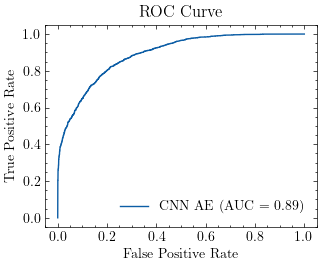

In [66]:
def plot_comparative_roc(results):
    """Plot ROC curve for CNN model"""
    for model_name, metrics in results.items():
        plt.plot(metrics['fpr'], metrics['tpr'],
                 label=f'{model_name} (AUC = {metrics["roc_auc"]:.2f})')

    # plt.plot([0, 1], [0, 1], color='navy', lw=2,
            #  linestyle='--', label='Random Guess')
    # plt.xlim([-0.01, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    # plt.grid(True)
    plt.show()

plot_comparative_roc({'CNN AE': result})

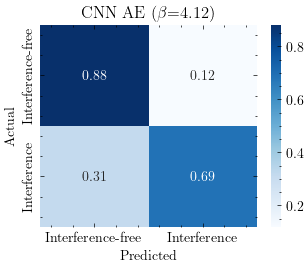

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comparative_confusion_matrices(results, normalize=True):
    """Plot normalized confusion matrices for CNN model."""
    for model_name, metrics in results.items():
        cm = metrics['confusion_matrix']
        
        if normalize:
            cm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)  # Normalize by row (true class)

        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues',
                    xticklabels=['Interference-free', 'Interference'],
                    yticklabels=['Interference-free', 'Interference'])

        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{model_name} ($\\beta$={metrics["threshold"]:.2f})')
        plt.show()

# Example usage:
plot_comparative_confusion_matrices({'CNN AE': result})
